In [1]:
import pandas as pd
# from piidetect.fakepii import Fake_PII, write_to_disk_train, write_to_disk_test
import os

print("Path at terminal when executing this file")
print(os.getcwd() + "\n")
#Make note of CWD- change it if you want- this is where your CSVs will end up

Path at terminal when executing this file
C:\Users\maddo\Downloads



In [2]:
from gensim.models import Word2Vec

In [3]:
fake_ = Fake_PII()
fake_.create_fake_profile(100)
train_labels, train_text, train_PII = fake_.create_pii_text_train(n_text = 5)
write_to_disk_train(300)
write_to_disk_test(300)

In [5]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [30]:
import re
train_data['Labels'].value_counts()
def clean_text(text):
    # replace  . and a space with only a space, then amke all words lower case.
    text = text.replace(". "," ").replace(",","").lower()
    # get rid of the . at the end of each line.
    cleaned_text = re.sub("\.$","",text)

    return cleaned_text
def extract_special_len(text):
    # the complete special char list
    all_special_char = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    # return the special char if it is in the text
    special_list = [special_char for special_char in all_special_char\
                   if special_char in text]

    return len(special_list)


def extract_special_char(text):
    # the complete special char list
    all_special_char = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    # return the special char if it is in the text
    special_list = [special_char for special_char in all_special_char\
                   if special_char in text]

    return special_list
train_data["Cleaned_text"] = train_data["Text"].apply(clean_text)
train_data['Special_char_num'] = train_data["Cleaned_text"].apply(extract_special_len)
train_data['Special_chars'] = train_data["Cleaned_text"].apply(extract_special_char)
train_data.groupby("Labels").agg({'Special_char_num':["min","max","mean",'median']})
test_data["Cleaned_text"] = test_data["Text"].apply(clean_text)
test_data['Special_char_num'] = test_data["Cleaned_text"].apply(extract_special_len)
test_data['Special_chars'] = test_data["Cleaned_text"].apply(extract_special_char)
test_data.groupby("Labels").agg({'Special_char_num':["min","max","mean",'median']})

Special_char_num                     
                              min max      mean median
Labels                                                
Address                         0   0  0.000000      0
CreditCardNumber                0   0  0.000000      0
Email                           2   2  2.000000      2
Name                            0   0  0.000000      0
None                            0   0  0.000000      0
Phone_number                    0   3  1.463333      1
Plates                          0   1  0.263333      0
SSN                             0   1  0.560000      1

In [7]:
# train_data.to_csv("train_cleaned.csv",index=False)
# test_data.to_csv("test_cleaned.csv",index=False)

#You can look at these in your CWD to check that everything worked and use the generated data later

In [37]:
fake_pii = train_data[["Text", "Labels", "PII", "Cleaned_text"]]
fake_pii['Target']= "1"
def binary_pii(label):
    pii_label = 0
    if label != "None":
        pii_label = 1
    return pii_label 
fake_pii["Target"] = fake_pii['Labels'].apply(binary_pii)
df = pd.DataFrame(data=fake_pii)
df2 = df.sample(n=10,replace=True)
df2

<ipython-input-37-030ac64f355f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_pii['Target']= "1"
<ipython-input-37-030ac64f355f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_pii["Target"] = fake_pii['Labels'].apply(binary_pii)


,Text,Labels,PII,Cleaned_text,Target
755,Energy lose cultural. Maintain always jamiejoh...,Email,jamiejohnson@example.org,energy lose cultural maintain always jamiejohn...,1
1872,Instead 728 27 3744 white name animal expect r...,SSN,728 27 3744,instead 728 27 3744 white name animal expect r...,1
1103,Series majority treatment. Certainly top image...,Name,Patricia Mora,series majority treatment certainly top image ...,1
877,Class line name john00@example.net later card ...,Email,john00@example.net,class line name john00@example.net later card ...,1
1207,120-157-1599x504 Those in wife political indiv...,Phone_number,120-157-1599x504,120-157-1599x504 those in wife political indiv...,1
1113,Standard soldier even trial apply. Some market...,Name,Sanders,standard soldier even trial apply some market ...,1
2245,Prevent become able firm. Force look whether t...,None,None,prevent become able firm force look whether tr...,0
72,Instead white 62371 Allison Row East Stephanie...,Address,"62371 Allison Row East Stephanie, IL 03958",instead white 62371 allison row east stephanie...,1
1853,Culture wind loss left adult. Interview 470 58...,SSN,470 58 6670,culture wind loss left adult interview 470 58 ...,1
1984,Arrive seem skill apply and ground. Produce re...,SSN,349 02 3390,arrive seem skill apply and ground produce rea...,1


In [9]:
context_sentences = [sentence.split(" ") for sentence in fake_pii.Cleaned_text]

In [10]:
word2vec_model = Word2Vec(context_sentences, vector_size = 20, window=5,
                                  min_count = 1, workers = 2)

In [11]:
import re
from tqdm import tqdm
import numpy as np

def find_part_pii(text, model, sep = " "):
    tokenized_text = text.split(sep)
    
    part_pii = model.wv.doesnt_match(tokenized_text)
    #save numerics/easy pii 
    return part_pii    



def get_word2vec_matrix(pii_list, model):
    # set the matrix dimensions
    column_num = 20
    row_num = len(pii_list)
    # initialized the matrix
    pii2vec_mat = np.zeros((row_num, column_num))
    # iterate through the pii_list and assign the vectors to matrix.
    for index, ith_pii in enumerate(tqdm(pii_list)):
        pii2vec_mat[index,:] = model.wv[ith_pii]
    
    return pii2vec_mat


def get_doc2vec_matrix(texts, model):
    """
    A helper function to get the vector for each document
    and combine it into a matrix. 
    """
    num_columns = 100
    num_rows = len(texts)
    
    doc2vec_pii_matrix = np.zeros((num_rows, num_columns))
    
    for index, text in enumerate(tqdm(texts)):
        
        doc2vec_pii_matrix[index,:] = model.infer_vector(text.split(" "))
        
    return doc2vec_pii_matrix


color_dict = {"Phone_number":"red","SSN":"blue","Address":"black","Name":"yellow",
             "Plates":"orange","CreditCardNumber":"purple","None":'pink',"Email":"tan"}


def _match_re_and_extract_cv_scores(model,all_cv_keys, regex):
    match_keys = re.findall(regex," ".join(all_cv_keys))
    
    cv_scores = dict()
    
    for key in match_keys:
        cv_scores[key] = model.cv_results_[key]
    return cv_scores 


def extract_sk_cv(model, test = True):
    """
    A helper function to extract the training/testing cross validation result
    """
    all_cv_keys = model.cv_results_.keys()
    
    if test:
        sk_cv_result =  _match_re_and_extract_cv_scores(model = model,all_cv_keys = all_cv_keys
                                                             ,regex = r"split[0-9]+_test_score")
        return pd.DataFrame(sk_cv_result)

    elif not test:
        
        sk_cv_result = _match_re_and_extract_cv_scores(model = model,all_cv_keys = all_cv_keys
                                                             ,regex = r"split[0-9]+_train_score")
        return pd.DataFrame(sk_cv_result)

In [12]:
pii_list = [find_part_pii(text, model = word2vec_model) for text in tqdm(fake_pii["Cleaned_text"]) ]

100%|██████████| 2400/2400 [00:00<00:00, 3389.50it/s]


In [13]:
pii_matrix = get_word2vec_matrix(pii_list = pii_list, model = word2vec_model)

100%|██████████| 2400/2400 [00:00<00:00, 66656.05it/s]


In [14]:

from sklearn.linear_model import LogisticRegression
from scipy.stats import expon
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(LogisticRegression(random_state=0 , max_iter=10000,n_jobs = 1))

param_grid = {
    'logisticregression__C':expon(scale = 2),
    'logisticregression__penalty':['l2']
}

random_cv_lr = RandomizedSearchCV(estimator= pipe, param_distributions = param_grid, cv =10, error_score = 0,
                               n_iter = 10 , scoring = 'f1', return_train_score=True,n_jobs = 2 )


random_cv_lr.fit(pii_matrix, fake_pii['Target'])

RandomizedSearchCV(cv=10, error_score=0,
                   estimator=Pipeline(steps=[('logisticregression',
                                              LogisticRegression(max_iter=10000,
                                                                 n_jobs=1,
                                                                 random_state=0))]),
                   n_jobs=2,
                   param_distributions={'logisticregression__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BAA8B393D0>,
                                        'logisticregression__penalty': ['l2']},
                   return_train_score=True, scoring='f1')

In [15]:
binary_pred = random_cv_lr.predict(pii_matrix)
binary_true = fake_pii["Target"]

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Text(51.0, 0.5, 'True values')

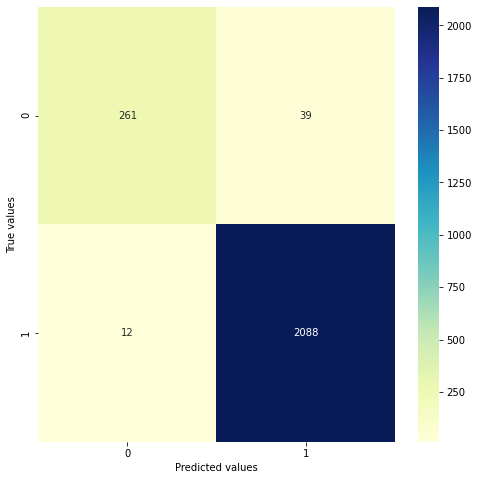

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize= (8,8))
sns.heatmap(confusion_matrix(y_true = binary_true, y_pred = binary_pred), annot = True,fmt="d",cmap="YlGnBu")
plt.xlabel("Predicted values")
plt.ylabel("True values")

In [18]:
print(classification_report(y_true = binary_true, y_pred = binary_pred))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91       300
           1       0.98      0.99      0.99      2100

    accuracy                           0.98      2400
   macro avg       0.97      0.93      0.95      2400
weighted avg       0.98      0.98      0.98      2400



In [19]:
random_cv_lr.best_estimator_

Pipeline(steps=[('logisticregression',
                 LogisticRegression(C=4.735935390112014, max_iter=10000,
                                    n_jobs=1, random_state=0))])

In [20]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import expon
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

# suppose the class_weight are 0.1 for 0 (no PII)  and 0.9 for 1 (PII exist)

pipe_lr_weights = make_pipeline(LogisticRegression(random_state=0 , max_iter=10000,n_jobs = 1,
                                                  class_weight={0:.1, 1:.9}) )
param_grid = {
              'logisticregression__C':expon(scale = 2),
              'logisticregression__penalty':['l2']
}

random_cv_lr_weights = RandomizedSearchCV(estimator= pipe_lr_weights, param_distributions = param_grid,
                                  cv =10, error_score = 0,n_iter = 10 , scoring = 'f1',
                                  return_train_score=True,n_jobs = 2 )
                               


random_cv_lr_weights.fit(pii_matrix, fake_pii['Target'])

RandomizedSearchCV(cv=10, error_score=0,
                   estimator=Pipeline(steps=[('logisticregression',
                                              LogisticRegression(class_weight={0: 0.1,
                                                                               1: 0.9},
                                                                 max_iter=10000,
                                                                 n_jobs=1,
                                                                 random_state=0))]),
                   n_jobs=2,
                   param_distributions={'logisticregression__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BAAB7BE460>,
                                        'logisticregression__penalty': ['l2']},
                   return_train_score=True, scoring='f1')

Text(51.0, 0.5, 'True values')

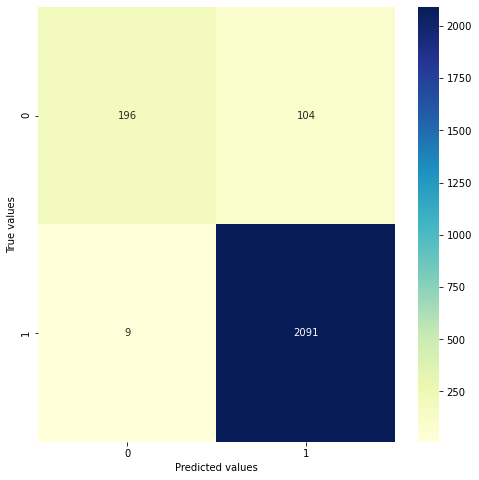

In [21]:
binary_pred = random_cv_lr_weights.predict(pii_matrix)
binary_true = fake_pii["Target"]

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report



import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize= (8,8))
sns.heatmap(confusion_matrix(y_true = binary_true, y_pred = binary_pred), annot = True,fmt="d",cmap="YlGnBu")
plt.xlabel("Predicted values")
plt.ylabel("True values")

In [22]:
print(classification_report(y_true = binary_true, y_pred = binary_pred))

              precision    recall  f1-score   support

           0       0.96      0.65      0.78       300
           1       0.95      1.00      0.97      2100

    accuracy                           0.95      2400
   macro avg       0.95      0.82      0.87      2400
weighted avg       0.95      0.95      0.95      2400



In [23]:
random_cv_lr_weights.best_estimator_

Pipeline(steps=[('logisticregression',
                 LogisticRegression(C=6.232756418568851,
                                    class_weight={0: 0.1, 1: 0.9},
                                    max_iter=10000, n_jobs=1,
                                    random_state=0))])

In [24]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

fake_pii = pd.read_csv('train_cleaned.csv')
paragraph = fake_pii['Cleaned_text'].copy()
tags = fake_pii['Labels'].copy()
fake_pii['Target']= "1"
fake_pii["Target"] = fake_pii['Labels'].apply(binary_pii)
True_tag_documents = [TaggedDocument(paragraph.iloc[index].split(" "), [tags.iloc[index]])\
                      for index in tqdm(range(len(tags)))]

100%|██████████| 2400/2400 [00:00<00:00, 9521.22it/s]


In [25]:
fake_pii.head

<bound method NDFrame.head of                                                    Text   Labels  \
0     Suddenly 51484 Ariana Track Suite 969 about se...  Address   
1     Yourself worry as serve rate. 014 Duncan Keys ...  Address   
2     Stock enter 559 Burgess Alley Suite 358 most m...  Address   
3     Mean maintain effort long. USS Stanley FPO AE ...  Address   
4     Level heavy remember risk certainly paper. Tal...  Address   
...                                                 ...      ...   
2395  Deal education Democrat just opportunity song....     None   
2396  Customer agent grow parent stay. Age affect ab...     None   
2397  Picture together budget side. Material nothing...     None   
2398  Physical opportunity allow rich. Tree door hop...     None   
2399  Fast despite later image wide. Drive federal t...     None   

                                                   PII  \
0                         51484 Ariana Track Suite 969   
1     014 Duncan Keys Apt. 979 Patter

In [26]:
true_tag_doc2vec_100 = Doc2Vec(True_tag_documents,vector_size = 100, min_count = 1, epochs = 15, workers = 2 )
pii_label_matrix_100 = get_doc2vec_matrix(texts = fake_pii['Cleaned_text'], model = true_tag_doc2vec_100)

100%|██████████| 2400/2400 [00:04<00:00, 504.69it/s]


In [27]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import expon
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline


pipe = make_pipeline(LogisticRegression(random_state=0 , max_iter=10000,n_jobs = 1))

param_grid = {
    'logisticregression__C':expon(scale = 2),
    'logisticregression__penalty':['l2']
}

random_cv_lr_label_100 = RandomizedSearchCV(estimator= pipe, param_distributions = param_grid, cv =10,
                                        error_score = 0,n_iter = 10 , scoring = 'f1',
                                        return_train_score=True,n_jobs = 2 )



random_cv_lr_label_100.fit(pii_label_matrix_100, fake_pii['Target'])

RandomizedSearchCV(cv=10, error_score=0,
                   estimator=Pipeline(steps=[('logisticregression',
                                              LogisticRegression(max_iter=10000,
                                                                 n_jobs=1,
                                                                 random_state=0))]),
                   n_jobs=2,
                   param_distributions={'logisticregression__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BAAB5FF340>,
                                        'logisticregression__penalty': ['l2']},
                   return_train_score=True, scoring='f1')

In [28]:
from sklearn.metrics import classification_report

binary_pred = random_cv_lr_label_100.predict(pii_label_matrix_100)
binary_true = fake_pii["Target"]
print(classification_report(y_true = binary_true, y_pred = binary_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.88      1.00      0.93      2100

    accuracy                           0.88      2400
   macro avg       0.44      0.50      0.47      2400
weighted avg       0.77      0.88      0.82      2400



C:\Users\maddo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(51.0, 0.5, 'True values')

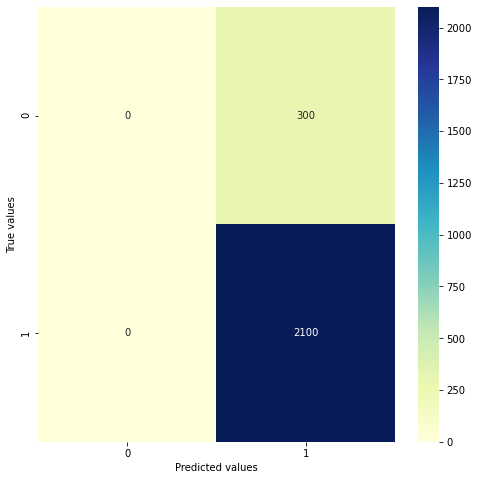

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
binary_pred = random_cv_lr_label_100.predict(pii_label_matrix_100)
binary_true = fake_pii["Target"]
plt.figure(figsize= (8,8))
sns.heatmap(confusion_matrix(y_true = binary_true, y_pred = binary_pred), annot = True,fmt="d",cmap="YlGnBu")
plt.xlabel("Predicted values")
plt.ylabel("True values")